This is the Notebook for the Araya coding work. All steps should be annotated for easy following. Any questions please contact Author.
I first carry out all imports. 
I get the Motor Imagery Dataset (BCI Competition IV Dataset 2a). I pre-process it as I see fit
 
I test a few decoding possibilities to pick which I will use for the online decoding. 
 - simple logistic regretion 
 - DL
 
I create server that streams the EEG dataset using LSL 
i get the client side that does online decoding with my model of choice 

In [198]:
import time

from pylsl import StreamInfo, StreamOutlet

import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from mne.decoding import CSP


import mne
from mne.datasets import eegbci #dataset of choice for challenge 
from mne.io import concatenate_raws, read_raw_edf
from mne.decoding import Vectorizer, FilterEstimator

from mne_realtime import StimServer
from mne_realtime import MockRtClient

import torch
import torch.nn as nn

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.optim as optim


In [199]:
#get mne dataset (raw)
# Download the dataset if not already downloaded
raw_fnames =eegbci.load_data(1, [6,10,14])# hands vs feet  
raws = [read_raw_edf(f, preload=True) for f in raw_fnames]
raw = concatenate_raws(raws)

Extracting EDF parameters from c:\Users\isabe\OneDrive\Documents\bmi_comp\datasets\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from c:\Users\isabe\OneDrive\Documents\bmi_comp\datasets\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from c:\Users\isabe\OneDrive\Documents\bmi_comp\datasets\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


In [200]:
#pre-processing
#filter raw data (8Hz,30Hz)
filtered_raw_data = raw.copy().filter(l_freq=0.1, h_freq=35, fir_design='firwin')
# raw_data.plot(title='no filter raw data')
# filtered_raw_data.plot(title='filtered data')
raw_data = filtered_raw_data
del filtered_raw_data
raw_data.rename_channels(lambda x: x.strip('.'))

# resample the data to 100Hz
raw_data.resample(sfreq=100)
print(raw_data.info)##



Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.1 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation


- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 5281 samples (33.006 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


<Info | 8 non-empty values
 bads: []
 ch_names: Fc5, Fc3, Fc1, Fcz, Fc2, Fc4, Fc6, C5, C3, C1, Cz, C2, C4, C6, ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.1 Hz
 lowpass: 35.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 100.0 Hz
 subject_info: 3 items (dict)
>


In [201]:
from mne.channels import make_standard_montage

# Set channel names
eegbci.standardize(raw_data)
montage = make_standard_montage('standard_1005')
raw_data.set_montage(montage)
print(raw_data.info)

<Info | 9 non-empty values
 bads: []
 ch_names: FC5, FC3, FC1, FCz, FC2, FC4, FC6, C5, C3, C1, Cz, C2, C4, C6, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.1 Hz
 lowpass: 35.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 100.0 Hz
 subject_info: 3 items (dict)
>


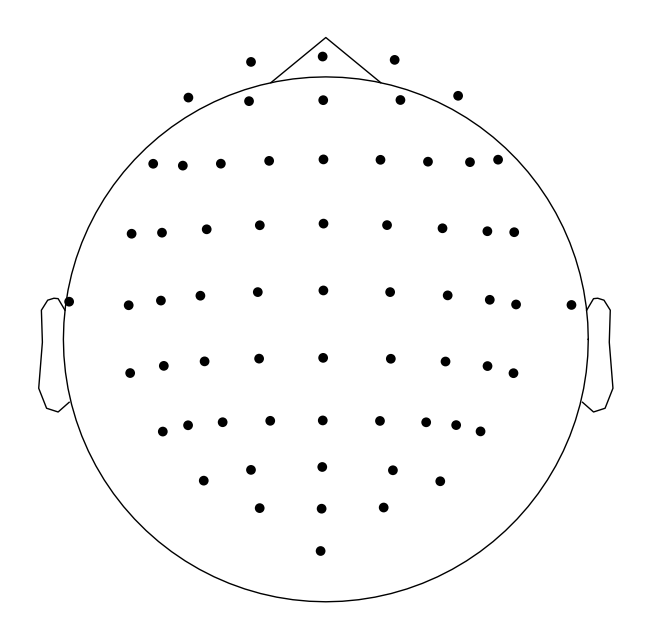

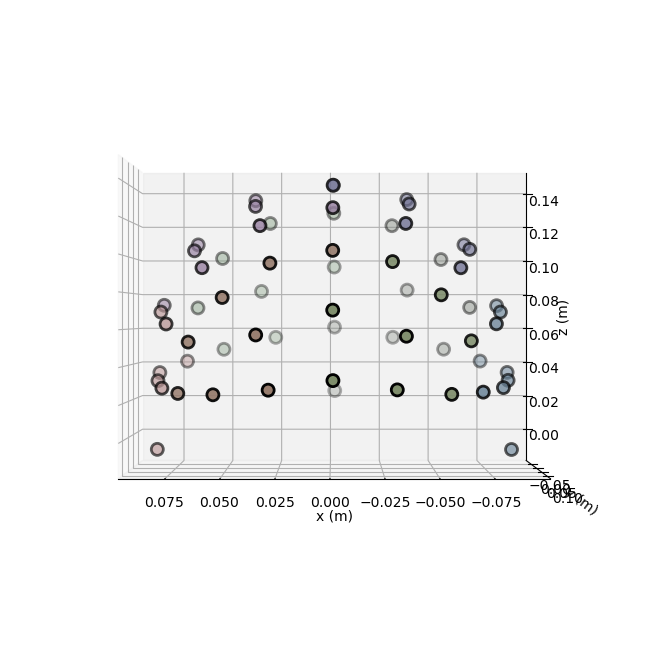

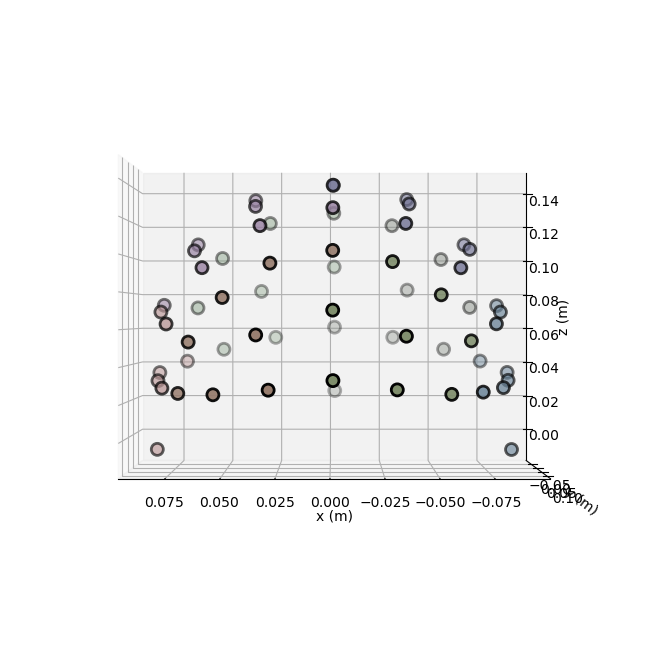

In [137]:
# Some visualisation 
raw_data.plot_sensors(ch_type='eeg')
raw_data.plot_sensors(kind='3d', ch_type='eeg', ch_groups='position')

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 20.480 (s)


c:\Users\isabe\anaconda3\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


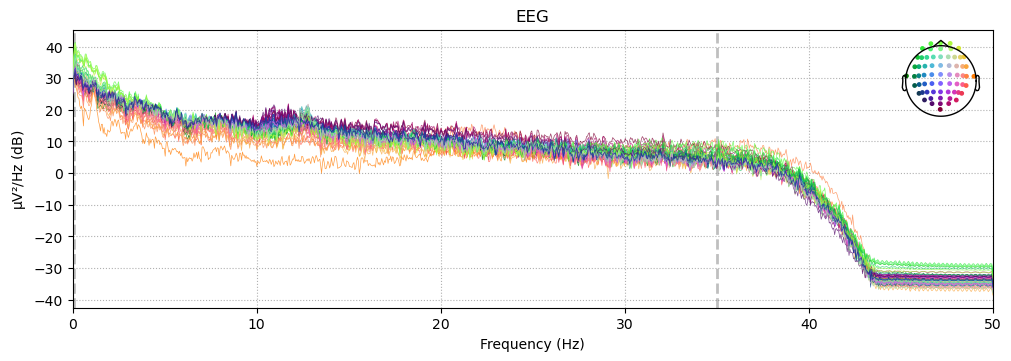

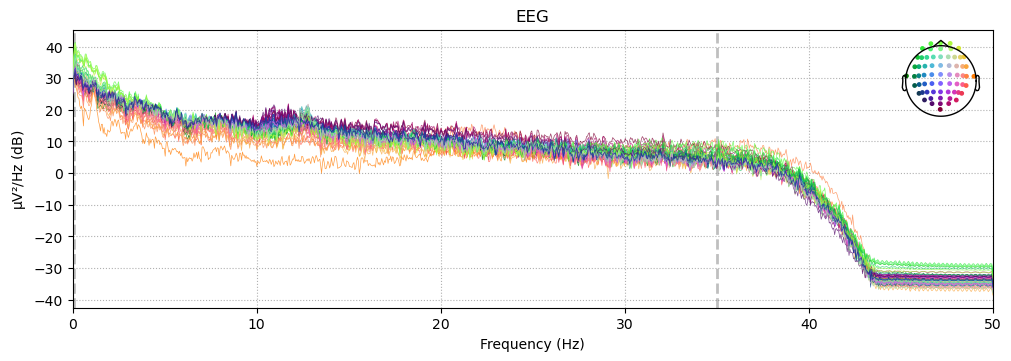

In [182]:
# plotting power specrum 
raw_data.plot_psd()

In [202]:
from mne import pick_types

# Select EEG channels
picks = pick_types(raw_data.info,
                   meg=False,
                   eeg=True,
                   stim=False,
                   eog=False,
                   exclude='bads')

In [203]:
from mne import Epochs, events_from_annotations
raw=raw_data
# Avoid classification of evoked responses by using epochs that start 1s after cue onset
tmin, tmax = -1, 4
event_id=dict(hands=2, feet=3)

# Get events from an Annotations object.
events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3))
print('Found {} events'.format(events.shape[0]))

picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")

# Read epochs (train will be done only between 1 and 2s)
# Testing will be done first with a running classifier
epochs = Epochs(
    raw,
    events,
    event_id,
    tmin,
    tmax,
    proj=True,
    picks=picks,
    baseline=None,
    preload=True,
)
epochs_train = epochs.copy().crop(tmin=1.0, tmax=2.0)
labels = epochs.events[:, -1] - 2

# Inspect epochs
print(epochs.info)
print('events x channels x samples:', epochs._data.shape)

# Get labels
labels = epochs.events[:, -1] - 2

Used Annotations descriptions: ['T1', 'T2']
Found 45 events
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 501 original time points ...
0 bad epochs dropped


<Info | 9 non-empty values
 bads: []
 ch_names: FC5, FC3, FC1, FCz, FC2, FC4, FC6, C5, C3, C1, Cz, C2, C4, C6, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.1 Hz
 lowpass: 35.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 100.0 Hz
 subject_info: 3 items (dict)
>
events x channels x samples: (45, 64, 501)


annotation info: <Annotations | 94 segments: BAD boundary (2), EDGE boundary (2), T0 (45), ...>
annotation duration:  [4.2 4.1 4.2 4.1 4.2 4.1 4.2 4.1 4.2]
annotation description:  {'T0', 'EDGE boundary', 'BAD boundary', 'T2', 'T1'}
Used Annotations descriptions: ['T0', 'T1', 'T2']


events:  [[   0    0    1]
 [ 420    0    3]
 [ 830    0    1]
 [1250    0    2]
 [1660    0    1]]
event dict:  {'T0': 1, 'T1': 2, 'T2': 3}


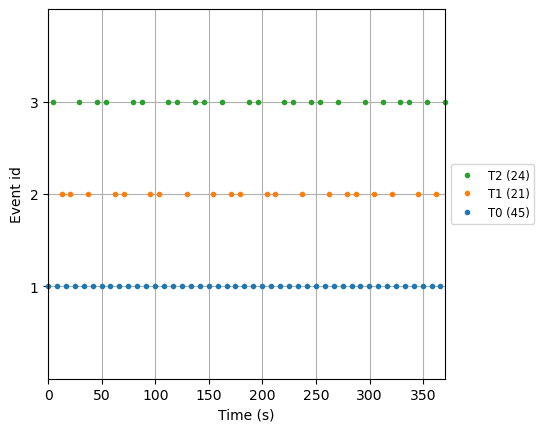

In [204]:
# check events 

# get the annotations(events) from raw data
print("annotation info:", raw_data.annotations)
print("annotation duration: ", raw_data.annotations.duration[:9])
print("annotation description: ", set(raw_data.annotations.description))

# Here is the description of every type:
# 'Rejected trial':1023,
# 'Eye movements':1072,
# 'Idling EEG (eyes open)':276,
# 'Idling EEG (eyes closed)':277,
# 'Start of a new run':32766,
# 'Start of a trial':768,
# *'Cue onset left (class 1)':769,
# *'Cue onset right (class 2)':770,
# *'Cue onset foot (class 3)':771,
# *'Cue onset tongue (class 4)':772

# get events from annotations
events, events_dict = mne.events_from_annotations(raw_data)
print("events: ", events[:5])
print("event dict: ", events_dict)
# event_dict is default to int from [1,n] n is the number of events

# visual the event distributed
events_fig = mne.viz.plot_events(events, sfreq=raw_data.info['sfreq'], first_samp=raw_data.first_samp, event_id=events_dict)


Effective window size : 20.480 (s)


c:\Users\isabe\anaconda3\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
c:\Users\isabe\anaconda3\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


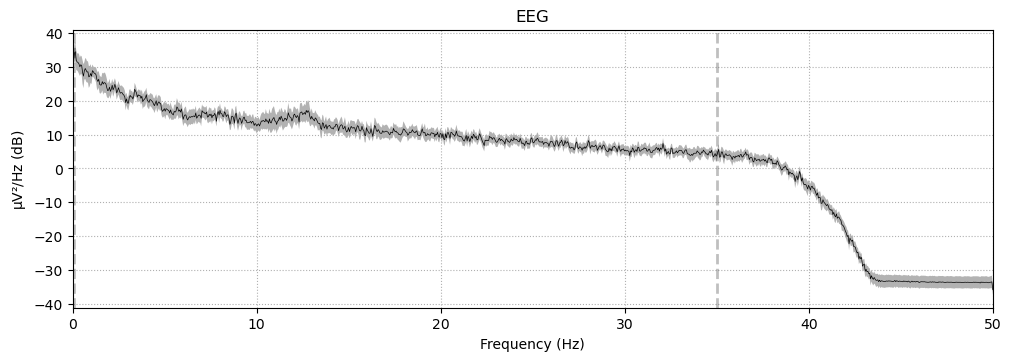

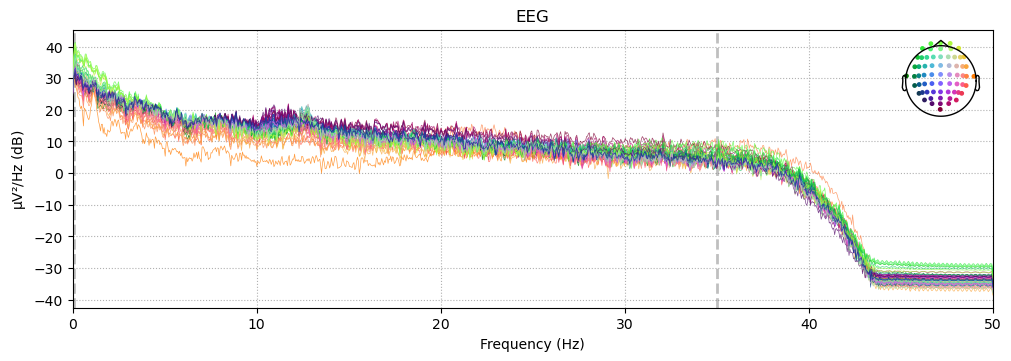

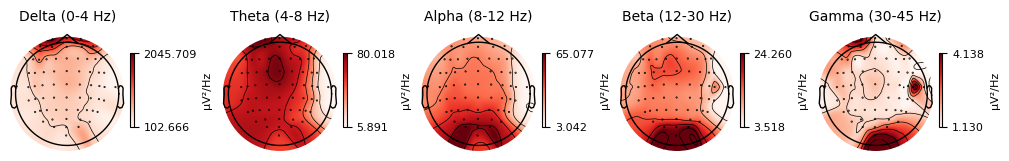

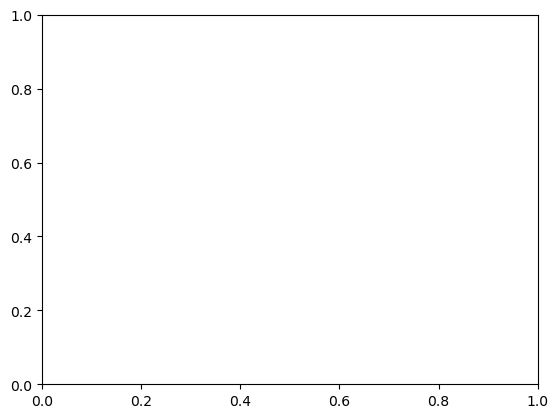

In [143]:
%matplotlib inline
# psd figure
spectrum = raw_data.compute_psd()
spectrum.plot(average=True)

# plot all channel
spectrum.plot()

# scalp topography
spectrum.plot_topomap()
plt.cla()

Not setting metadata
24 matching events found


No baseline correction applied
0 projection items activated
combining channels using "mean"


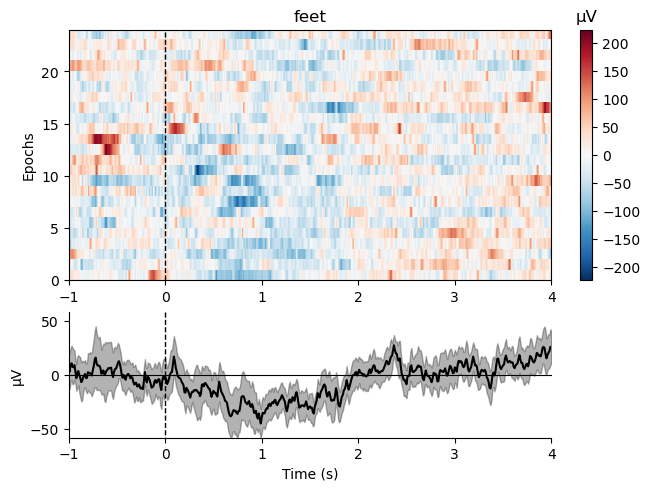

Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


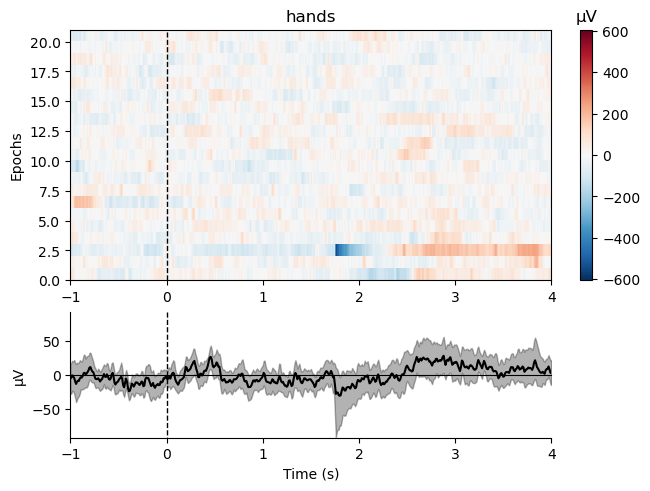

[<Figure size 640x480 with 3 Axes>]

In [186]:
# visualize the average epochs fig for 4 classes
epochs['feet'].plot_image(title='feet', combine='mean')
epochs['hands'].plot_image(title='hands', combine='mean')

In [205]:

# Prepare features and labels
X = epochs.get_data()  # EEG data
y = epochs.events[:, -1]  # Event labels (feet vs hands)

print(labels)


[1 0 0 1 0 1 1 0 0 1 1 0 0 1 1 0 1 1 0 1 0 0 1 1 0 0 1 1 0 1 1 0 1 0 0 1 0
 1 0 1 1 0 1 0 1]


C:\Users\isabe\AppData\Local\Temp\ipykernel_25032\3256665225.py:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X = epochs.get_data()  # EEG data


Now We have the data set up, I will carry out different classifications to then pick the prefered popeline

In [206]:
# start simple with a K-fold cross validation 
cv = KFold(n_splits=10, shuffle=True, random_state=42)
#epochs_data = 1e6 * epochs.get_data()

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=2, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([('CSP', csp), ('LDA', lda)])
scores = cross_val_score(clf, X, labels, cv=cv, n_jobs=1)

class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("CSP + LDA Classification accuracy: %f / Chance level: %f" 
                                  % (np.mean(scores), class_balance))

Computing rank from data with rank=None


    Using tolerance 0.00058 (2.2e-16 eps * 64 dim * 4.1e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00051 (2.2e-16 eps * 64 dim * 3.6e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00045 (2.2e-16 eps * 64 dim * 3.2e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00055 (2.2e-16 eps * 64 dim * 3.9e+10  max singular value)
    Estimated rank (mag): 64
    MAG: ra

Computing rank from data with rank=None
    Using tolerance 0.00017 (2.2e-16 eps * 64 dim * 1.2e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00022 (2.2e-16 eps * 64 dim * 1.6e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None


    Using tolerance 0.00017 (2.2e-16 eps * 64 dim * 1.2e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00022 (2.2e-16 eps * 64 dim * 1.6e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00028 (2.2e-16 eps * 64 dim * 2e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00019 (2.2e-16 eps * 64 dim * 1.4e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank

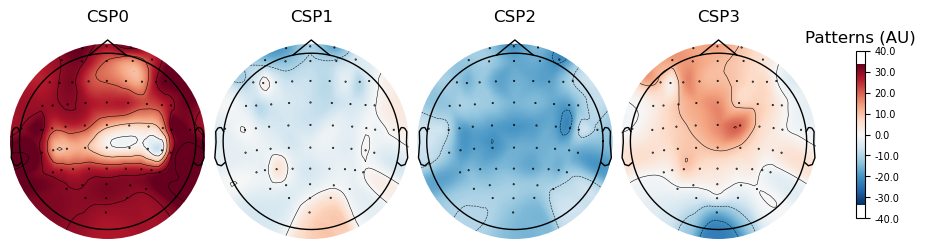

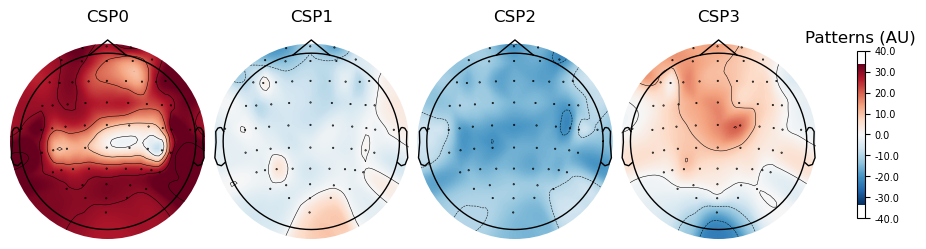

In [189]:
from sklearn.model_selection import ShuffleSplit, cross_val_score

# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
epochs_data = epochs.get_data(copy=False)
epochs_data_train = epochs_train.get_data(copy=False)
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([("CSP", csp), ("LDA", lda)])
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=None)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1.0 - class_balance)
print(
    "Classification accuracy: %f / Chance level: %f" % (np.mean(scores), class_balance)
)

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epochs_data, labels)

csp.plot_patterns(epochs.info, ch_type="eeg", units="Patterns (AU)", size=1.5)

Computing rank from data with rank=None
    Using tolerance 6.5e+02 (2.2e-16 eps * 64 dim * 4.6e+16  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.6e+02 (2.2e-16 eps * 64 dim * 4.7e+16  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.


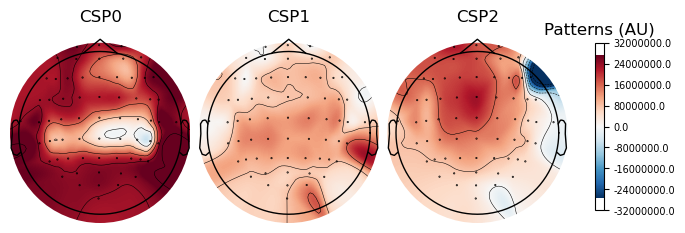

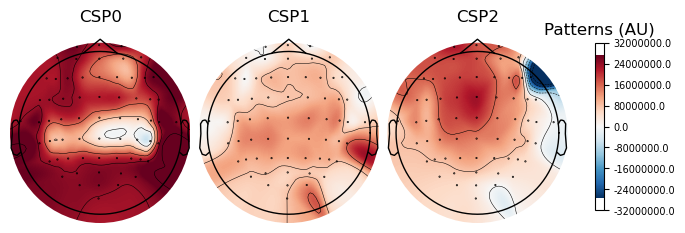

In [45]:
csp.fit_transform(epochs_data, labels)
csp.plot_patterns(epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5)


In [151]:
labels.shape

(45,)

In [105]:
class EEGNet(nn.Module):
    def __init__(self, num_channels=64, num_classes=3):
        super(EEGNet, self).__init__()
        self.conv1 = nn.Conv2d(1, num_channels, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32))
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=(2, 32), stride=(1, 1), padding=(0, 16))
        self.bn2 = nn.BatchNorm2d(num_channels)
        self.fc1 = nn.Linear(num_channels * 2 * 16, 128)  # Adjusted input size
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x.unsqueeze(1))  # Add a channel dimension
        x = self.bn1(x)
        x = torch.relu(x)
        x = torch.max_pool2d(x, kernel_size=(1, 4), stride=(1, 4))
        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = torch.max_pool2d(x, kernel_size=(1, 4), stride=(1, 4))
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [117]:
class Conv2dWithConstraint(nn.Conv2d):
    def __init__(self, *args, max_norm=1, **kwargs):
        self.max_norm = max_norm
        super(Conv2dWithConstraint, self).__init__(*args, **kwargs)

    def forward(self, x):
        self.weight.data = torch.renorm(
            self.weight.data, p=2, dim=0, maxnorm=self.max_norm
        )
        return super(Conv2dWithConstraint, self).forward(x)

class EEGNetReproduce(nn.Module):
    def __init__(self, n_channels, n_classes, input_window_size,
                 F1=8, D=2, F2=16, kernel_length=64, drop_p=0.25):
        super(EEGNetReproduce, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.F1 = F1
        self.D = D
        self.F2 = F2
        self.kernel_length = kernel_length
        self.drop_p = drop_p
        self.input_windows_size = input_window_size
        self.block_temporal_conv = nn.Sequential(
            nn.Conv2d(1, self.F1, (1, self.kernel_length),
                      stride=1, bias=False, padding='same'),
            nn.BatchNorm2d(self.F1)
        )
        self.block_spacial_conv = nn.Sequential(
            Conv2dWithConstraint(self.F1, self.F1 * self.D, (self.n_channels, 1),
                                 max_norm=1, stride=1, bias=False, groups=self.F1, padding=(0, 0)),
            nn.BatchNorm2d(self.F1 * self.D),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 4), stride=(1, 4)),
            nn.Dropout(p=self.drop_p)
        )
        self.block_separable_conv = nn.Sequential(
            nn.Conv2d(self.F1 * self.D, self.F1 * self.D, (1, 16),
                      stride=1, bias=False, groups=self.F1 * self.D, padding='same'),
            nn.Conv2d(self.F1 * self.D, self.F2, (1, 1),
                      stride=1, bias=False, padding=(0, 0)),
            nn.BatchNorm2d(self.F2),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 8), stride=(1, 8)),
            nn.Dropout(p=self.drop_p),
            nn.Flatten()
        )
        block_conv = nn.Sequential(
            self.block_temporal_conv,
            self.block_spacial_conv,
            self.block_separable_conv
        )
        out = block_conv(torch.ones((1, 1, self.n_channels, self.input_windows_size), dtype=torch.float32))
        self.block_classifier = nn.Sequential(
            nn.Linear(out.cpu().data.numpy().shape[1], self.n_classes),
            # nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        while len(x.shape) < 4:
            x = x.unsqueeze(-1)
        x = x.permute(0, 3, 1, 2)
        x = self.block_temporal_conv(x)
        x = self.block_spacial_conv(x)
        x = self.block_separable_conv(x)
        x = self.block_classifier(x)
        return x

class eegNet(nn.Module):
    def initialBlocks(self, dropoutP, *args, **kwargs):
        block1 = nn.Sequential(
                nn.Conv2d(1, self.F1, (1, self.C1),
                          padding = (0, self.C1 // 2 ), bias =False),
                nn.BatchNorm2d(self.F1),
                Conv2dWithConstraint(self.F1, self.F1 * self.D, (self.nChan, 1),
                                     padding = 0, bias = False, max_norm = 1,
                                     groups=self.F1),
                nn.BatchNorm2d(self.F1 * self.D),
                nn.ELU(),
                nn.AvgPool2d((1,4), stride = 4),
                nn.Dropout(p = dropoutP))
        block2 = nn.Sequential(
                nn.Conv2d(self.F1 * self.D, self.F1 * self.D,  (1, 22),
                                     padding = (0, 22//2) , bias = False,
                                     groups=self.F1* self.D),
                nn.Conv2d(self.F1 * self.D, self.F2, (1,1),
                          stride =1, bias = False, padding = 0),
                nn.BatchNorm2d(self.F2),
                nn.ELU(),
                nn.AvgPool2d((1,8), stride = 8),
                nn.Dropout(p = dropoutP)
                )
        return nn.Sequential(block1, block2)

    def lastBlock(self, inF, outF, kernalSize, *args, **kwargs):
        return nn.Sequential(
                nn.Conv2d(inF, outF, kernalSize, *args, **kwargs),
                nn.LogSoftmax(dim = 1))

    def calculateOutSize(self, model, nChan, nTime):
        '''
        Calculate the output based on input size.
        model is from nn.Module and inputSize is a array.
        '''
        data = torch.rand(1,1,nChan, nTime)
        model.eval()
        out = model(data).shape
        return out[2:]

    def __init__(self, nChan, nTime, nClass = 2,
                 dropoutP = 0.25, F1=8, D = 2,
                 C1 = 125, *args, **kwargs):
        super(eegNet, self).__init__()
        self.F2 = D*F1
        self.F1 = F1
        self.D = D
        self.nTime = nTime
        self.nClass = nClass
        self.nChan = nChan
        self.C1 = C1

        self.firstBlocks = self.initialBlocks(dropoutP)
        self.fSize = self.calculateOutSize(self.firstBlocks, nChan, nTime)
        self.lastLayer = self.lastBlock(self.F2, nClass, (1, self.fSize[1]))

    def forward(self, x):
        x = self.firstBlocks(x)
        x = self.lastLayer(x)
        x = torch.squeeze(x, 3)
        x = torch.squeeze(x, 2)

        return x


class BaseCNN(nn.Module):
    def __init__(self, n_channels, n_classes, input_window_size):
        super(BaseCNN, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.input_window_size = input_window_size
        self.block_conv = nn.Sequential(
            nn.Conv2d(64, 16, (1, 8), stride=1, padding='same'),
            nn.BatchNorm2d(16, momentum=0.01, eps=1e-3),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 8), stride=(1, 8)),
            nn.Dropout(p=0.5)
        )
        self.block_classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.5),
            nn.Linear(self.input_window_size // 8 * self.n_channels * 16, 64),
            nn.Linear(64, self.n_classes),
            # nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = transpose_to_4d_input(x)
        x = self.block_conv(x)
        x = self.block_classifier(x)
        return x

def transpose_to_4d_input(x):
    # Reshape the input tensor to have dimensions (batch_size, channels, height, width)
    return x.unsqueeze(1)

In [119]:
n_channels = 64  # number of input channels
n_classes = 3 #  number of output classes
input_window_size = 512  # Example size of the input window
modelEEG = eegNet(n_channels, 161)
optimizer = torch.optim.Adam(modelEEG.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [156]:

# Convert the data into PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Compute mean and standard deviation along the channel axis
#mean = torch.mean(X_train_tensor, dim=(0, 2, 3), keepdim=True)
#std = torch.std(X_train_tensor, dim=(0, 2, 3), keepdim=True)

# Normalize the training data
#X_train_normalized = (X_train_tensor - mean) / std

# Normalize the test data using the mean and std from the training data
##X_test_normalized = (X_test_tensor - mean) / std

# Compute mean and standard deviation along the channel axis
#mean = torch.mean(X_train_tensor, dim=(0, 2), keepdim=True)
#std = torch.std(X_train_tensor, dim=(0, 2), keepdim=True)

# Normalize the training data
#X_train_normalized = (X_train_tensor - mean) / std

# Normalize the test data using the mean and std from the training data
#X_test_normalized = (X_test_tensor - mean) / std
# Create a DataLoader for training and testing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=64)

combining channels using "gfp"
combining channels using "gfp"


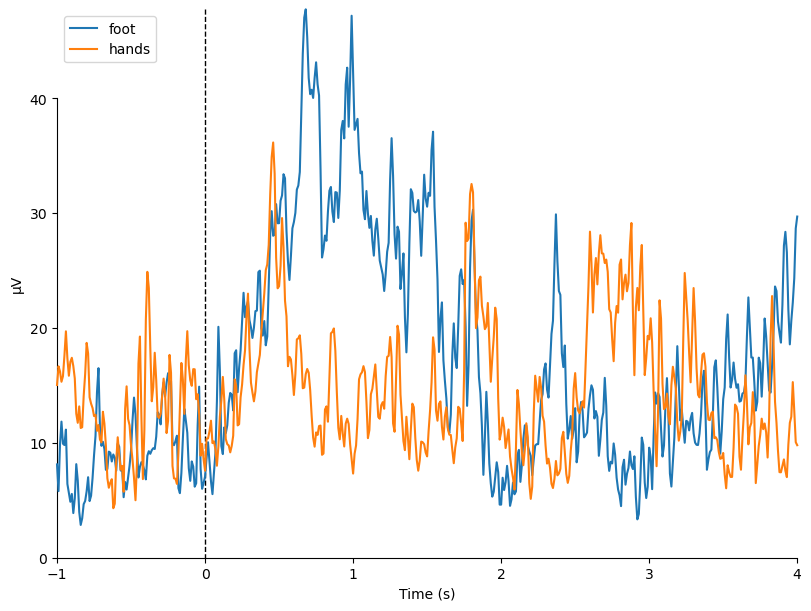

[<Figure size 800x600 with 1 Axes>]

In [191]:
#plot the evoked fig
evoked_dict = {'foot': epochs['feet'].average(), 'hands': epochs['hands'].average()}
mne.viz.plot_compare_evokeds(evoked_dict)

In [196]:

import torch.nn.functional as F

class EEGNet(nn.Module):
    def __init__(self, n_classes, Chans=64, Samples=72, dropoutRate=0.5):
        super(EEGNet, self).__init__()
        self.Chans = Chans
        self.Samples = Samples
        self.drop = nn.Dropout(dropoutRate)
        self.relu = nn.ReLU()

        # Layer 1
        self.conv1 = nn.Conv2d(1, 16, (1, 51), padding=(0, 0))
        self.bn1 = nn.BatchNorm2d(16, eps=1e-5)
        
        # Layer 2
        self.conv2 = nn.Conv2d(16, 32, (Chans, 1), padding=(0, 0))
        self.bn2 = nn.BatchNorm2d(32, eps=1e-5)

        # Layer 3
        self.conv3 = nn.Conv2d(32, 32, (1, 11), padding=(0, 5))
        self.bn3 = nn.BatchNorm2d(32, eps=1e-5)
        self.pooling3 = nn.MaxPool2d(1, 4)
        
        # Layer 4
        self.conv4 = nn.Conv2d(32, Chans, (1, 7), padding=(0, 3))
        self.bn4 = nn.BatchNorm2d(Chans, eps=1e-5)
        self.pooling4 = nn.MaxPool2d(1, 4)

        # FC Layer
        self.fc1 = nn.Linear(Chans * int(Samples / 16), n_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add a channel dimension
        # Layer 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.drop(x)

        # Layer 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.drop(x)

        # Layer 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pooling3(x)
        x = self.drop(x)

        # Layer 4
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.pooling4(x)
        x = self.drop(x)

        # FC Layer
        x = x.view(-1, self.fc1.in_features)  # Flatten
        x = self.fc1(x)
        
        return x
# Instantiate the model
model = EEGNet(n_channels, 2, 351 )

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    for inputs, labels in train_dataloader:  # Iterate over training dataset
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights

    # Print the loss after each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_dataloader:  # Iterate over test dataset
        outputs = model(inputs)  # Forward pass
        _, predicted = torch.max(outputs, 1)  # Get the predicted class
        total += labels.size(0)  # Increment the total number of samples
        correct += (predicted == labels).sum().item()  # Increment the number of correctly predicted samples

# Calculate accuracy
accuracy = 100 * correct / total
print(f'Accuracy on test set: {accuracy:.2f}%')


RuntimeError: shape '[-1, 42]' is invalid for input of size 9728

In [121]:

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    modelEEG.train()  # Set the model to training mode
    for inputs, labels in train_dataloader:  # Iterate over training dataset
        optimizer.zero_grad()  # Zero the gradients
        outputs = modelEEG(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights

    # Print the loss after each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation
modelEEG.eval()  # Set the model to evaluation mode
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_dataloader:  # Iterate over test dataset
        outputs = modelEEG(inputs)  # Forward pass
        _, predicted = torch.max(outputs, 1)  # Get the predicted class
        total += labels.size(0)  # Increment the total number of samples
        correct += (predicted == labels).sum().item()  # Increment the number of correctly predicted samples

# Calculate accuracy
accuracy = 100 * correct / total
print(f'Accuracy on test set: {accuracy:.2f}%')

RuntimeError: Given groups=1, weight of size [8, 1, 1, 125], expected input[1, 64, 64, 351] to have 1 channels, but got 64 channels instead

In [109]:
class BaseCNN(nn.Module):
    def __init__(self, n_channels, n_classes, input_time_steps):
        super(BaseCNN, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.input_time_steps = input_time_steps
        
        # Define the convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(1, 8), stride=1, padding=(0, 0))
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.AvgPool2d(kernel_size=(1, 8), stride=(1, 8))
        
        # Calculate the number of output features from convolutional layers
        conv_out_time_steps = (input_time_steps - 8 + 1) // 8
        
        # Define the fully connected layers
        self.fc1 = nn.Linear(16 * n_channels * conv_out_time_steps, 64)
        self.fc2 = nn.Linear(64, n_classes)
        
        # Define the dropout layer
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, x):
        # Add a channel dimension to the input data
        x = x.unsqueeze(1)
        
        # Apply convolutional layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        # Reshape the output for fully connected layers
        x = x.view(x.size(0), -1)
        
        # Apply fully connected layers
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [116]:
n_channels = 64  # Number of input channels
n_classes = 3 # Number of output classes
input_time_steps = 161  # Number of time steps in input data

# Initialize the model
model = EEGNetReproduce(n_channels=n_channels, n_classes=n_classes, input_window_size=1.024)

TypeError: ones(): argument 'size' failed to unpack the object at pos 4 with error "type must be tuple of ints,but got float"

In [111]:
# Train [model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: {100 * correct / total:.2f}%')

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x44032 and 19456x64)

Now I have understood how the data behaves with my models, I will build the server and client stream:

In [84]:
# Server 
# Define constants
channels = 64  # Number of EEG channels
sampling_rate = 160  # Sampling rate in Hz
stream_name = 'MotorImageryStream'
stream_type = 'EEG'

# Create a stream info object
info = StreamInfo(stream_name, stream_type, channels, sampling_rate, 'float32', 'myuid12345')

# Create a stream outlet
outlet = StreamOutlet(info)

#lets do it!
print("Streaming EEG data...")
# streaming EEG data
while True:
    # get data
    eeg_data = X_test
    
    # Send the EEG data sample
    outlet.push_sample(eeg_data)
    
    # Sleep for a short duration to control the data stream rate
    time.sleep(1/sampling_rate)
print("Streaming finished.")


Streaming EEG data...


TypeError: only length-1 arrays can be converted to Python scalars

In [83]:
X_test.shape

(18, 64, 161)

In [ ]:
# client side
streams = resolve_stream('type', 'EEG')

# Create an inlet to receive the EEG stream
inlet = StreamInlet(streams[0])

# Receive and decode EEG data
print("Receiving EEG data...")
try:
    while True:
        # Receive a chunk of EEG data
        chunk, timestamps = inlet.pull_chunk(timeout=1.0)
        
        # Check if any data chunk was received
        if chunk:
            # Process and decode the received EEG data
            for sample in chunk:
                # Perform decoding or analysis on the EEG data
                # Example: Print the received EEG sample
                print("Received EEG sample:", sample)
except KeyboardInterrupt:
    print("Client stopped.")